# ETH Maxi DegenVault Backtest

## Core idea

Following on from Brahma's first DegenVault, The Protected Moonshot USDC DegenVault, the next natural product extension was to create an ETH vault. 

The core strategy idea remains the same but deposits are received in ETH. These ETH deposits are used to provide liquidity to certain Curve LP pools (think ETH/stETH pool or the rETH/stETH pool or even the sETH2/stETH pool) and the LP tokens staked on Convex. Weekly the yield generated is harvested and this yield is used to take leveraged bets on crypto asset prices with aim of enhancing the DeFi native yields without putting the initial capital at risk.

This notebook aims to analyse the vault returns for a variety of leveraged bet strategies. We investigate three different on-chain products that can be used to take leveraged bets on cryto asset prices: perpetual futures, vanilla options and squeeth (opyns implementation of a ETH^2 power perpetual).

The notebook is structured as follows: First, the relevant data required for backtesting these strategies are imported and analysed for suitability. Then the performance of a various derivative based trading strategies are investigated.  The key drivers of returns for the most promising strategies are then investigated which guide further strategy improvements. Finally these improved strategies are compared and contrasted to the base strategies and conclusion are presented. 

## Implementation

### Imports

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime,timedelta

import sys
sys.path.append("../")
import utils
from option_utils import runOptionBacktest,runSqueethBacktest
from perp_utils import runPerpBacktest
sns.set(palette='deep')

###  Data

For this backtest we gather 1year of historical data consisting of:
 * Hourly history of Deribit's Volatility Index: ETH DVOL
 * FTX price history data for ETH
 * 1-week at-the-money ETH implied volatility data from Deribit - we are constrained to using historical options data from centralised exchanges such as Deribit since onchain options are such a new primitive there is not sufficient history to perform a robust backtest. 

In [2]:
# Import Deribit DVOL historical data.
dvol_raw = pd.read_csv("../data/deribitETHDVOL1616745600000_1648800000000.csv")
hourly_dvol,weekly_dvol = utils.dvolTransformer(dvol_raw)

# Import FTX historical price data.
ftx_raw = pd.read_csv("../data/ftx_PriceDataETH-PERP_1616140800_1648800000.csv")
hourly_data,weekly_data = utils.ftxTransformer(ftx_raw)


# Import 1week atm IV data.
skew_data_raw = pd.read_csv("../data/skew_eth_atm_implied_volatility_Mar21_Apr22.csv")
hourly_skew_data,weekly_skew_data = utils.skewDataTransformer(skew_data_raw)


### Deeper Analysis of Implied Volatility Data

In order to backtest any option strategy, one needs historical implied volatility data. 

We examine two sources, _Deribit ETH DVOL_ volatility index and _1week atm ETH Implied Volatility_ data. 
Our goal is to compare and access whether the two exibit similar behaviour and are suitable to use in our strategy.

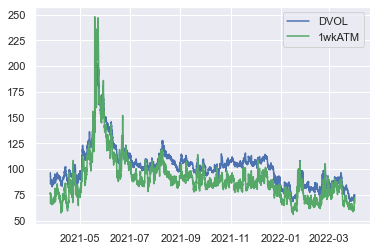

In [3]:
#Plot compare DVOL and 1weekATM implied volatilities
plt.plot(hourly_dvol.dvol_close,color='b')
plt.plot(hourly_skew_data.close,color='g')
plt.legend(['DVOL','1wkATM'])
plt.show()


DVOL is a VIX-like volatility index and uses a variance swap-like formula i.e. it takes into account the implied volatility of the entire skew. 

Since ETH options tend to trade on a smile** we expect DVOL to typically be higher than the current ATM IV, which is supported by the behaviour shown in the chart. Hence, it can also be considered a fear-measure.

We therefore stick to using 1week ATM implied volatility data for our testing of option based strategies since this will give a better indication of where close to atm options can be purchased and sold at a point in time
___
_*Trading on a smile_ means that otm put and call iv's are higher than atm iv's




### Additional data processing

For our weekly leveraged bets, our systems determines the trade direction based on a simple momentum strategy. In order to calculate this we need to additionaly generate the simple moving average(SMA) on daily data and then combine all availiable information in our weekly dataframe. We also generate realised volatility for further trade return analysis.

The chosen hyperparameter for our model is the SMA window size. For the current example we assume the window size of 5 days based on the empirical experience. The window size for the realised is chosen to be 7days to line up with the trade horizon. 

In [4]:
# Generate data and then add to weeklyData Dataframe (the central price data input)
ma_window = '5d'
rv_window = '7d'

moving_avg = utils.create_moving_avg(hourly_data,weekly_data,ma_window)
rv_start,rv_end = utils.create_realised_vol(hourly_data,weekly_data,rv_window)

weekly_data['moving_avg'] = moving_avg
weekly_data['realised_vol_start'] = rv_start
weekly_data['realised_vol_end'] = rv_end

# Don't have enough price data for signal calc at start of first week so drop
weekly_data.drop(index=weekly_data.index[0], 
    axis=0, 
    inplace=True)




## Backtest

The primary goal of our backtest is to find the derivative strategy that generates the best yield enhancement for a ETH denominated vault. 

For the sake of consistency we keep our signalling logic the same as it is for the current PMUSDC vault - a momentum signal based on a simple moving average. 

### Compare ETH Returns for a Range of Strategies

Currently the PMUSDC Vault  runs an _enhanced_* perpetual future strategy. We compare the ETH returns for the existing perp strategy perfomance, both simple and enhanced variations, to that of the other potential strategies that utilise options and squeeth. 


___
_*Enhanced_ here means the addition of the continuously monitored "take profit" and "stop loss" levels

In [5]:
#Perp Strategy specific params
leverage = 8.0
mm_min = 0.0625 # maintanence margin required for perp protocol
take_profit = 0.20 # take profit for enhanced strat
stop_loss = 0.05 # stop loss for enhanced strat

#Option Strategy specific params
r = 0 # r used in option pricing formula
strike_rounding = True # whether to apply rounding to option strikes
otm_percentage = 0 # % OTM of strike to buy/sell
bid_offer_spread = 3.0 # IV data is mid volatilities, add vol spread to get traded vol

#Squeeth specific params
f = 17.5/365 #funding period - premium paid over 17.5days
n0 = 0.9 # initial normalisation factor

#General Parameters
capital = 100 #starting capital
base_yield = 0.06 # convex deposit yield
freq = 7 #interest harvest and trade frequency (days)
interest = capital*base_yield*freq/365

data_store = pd.DataFrame()

signal_choice = ['100%Accurate','long_only','short_only','momentum']

for strat in signal_choice:

    # Determine weekly strategy position
    # 1: bullish trade
    # -1: bearish trade
    if strat == '100%Accurate':
        weekly_data['position'] = np.where(weekly_data.price_change>0,1,-1) #see the future
    elif strat == 'momentum':
        weekly_data['position'] = np.where(weekly_data.open > weekly_data.moving_avg,1,-1)
    elif strat == 'long_only':
        weekly_data['position'] = 1
    elif strat == 'short_only':
        weekly_data['position'] = -1
        
        
    perp_simple, perp_alpha = runPerpBacktest(weekly_data,hourly_data,freq,leverage,mm_min,interest,'ETH','simple')
    perp_enhanced, perp_alpha_enhanced = runPerpBacktest(weekly_data,hourly_data,freq,leverage,mm_min,interest,'ETH','enhanced',take_profit,stop_loss)

    option_buyer,option_buyer_alpha = runOptionBacktest(weekly_data,weekly_skew_data+bid_offer_spread/2,freq,interest,'ETH',r,otm_percentage,'optionBuyer',strike_rounding)

    option_seller,option_seller_alpha = runOptionBacktest(weekly_data,weekly_skew_data-bid_offer_spread/2,freq,interest,'ETH',r,otm_percentage,'optionSeller',strike_rounding)

    straddle_buy,straddle_buy_alpha = runOptionBacktest(weekly_data,weekly_skew_data+bid_offer_spread/2,freq,interest,'ETH',r,otm_percentage,'straddleBuyer',strike_rounding)

    straddle_sell,straddle_sell_alpha = runOptionBacktest(weekly_data,weekly_skew_data-bid_offer_spread/2,freq,interest,'ETH',r,otm_percentage,'straddleSeller',strike_rounding)

    squeeth, squeeth_alpha  = runSqueethBacktest(weekly_data,weekly_skew_data,hourly_skew_data,freq,interest,'ETH',f,n0)

    accuracy = ((weekly_data.position * weekly_data.price_change) > 0 ).sum() / weekly_data.shape[0]
    
    store = {'SignalAccuracy':accuracy,'PerpSimple':perp_alpha,'PerpEnhanced':perp_alpha_enhanced,
                 'OptionBuy':option_buyer_alpha,'OptionSell':option_seller_alpha,'Squeeth':squeeth_alpha,
                 'StraddleBuy':straddle_buy_alpha,'StraddleSell':straddle_sell_alpha}

    
    store = pd.DataFrame.from_dict(store,orient='index')
    store.rename(columns={0:strat},inplace=True)

    data_store = pd.concat([data_store,store],axis=1)


First some details on the strategies tested:
 * PerpSimple: 8x leveraged perp trade taken with direction given by signal
 * PerpEnhanced: Current PMUSDC strategy, 8x leveraged perp trade taken with direction given by signal. Trade is  continuously monitored and closed if stop loss and take profit conditions met
 * OptionBuy: Weekly yield is used to purchase a 1week ATM option, put/call decision determined by signal
 * OptionSell: Weekly yield is used as collateral to write a 1week ATM option, put/call decision determined by signal
 * Squeeth: If bullish signal, weekly yield is used to purchase oSQTH tokens; if bearish signal, weekly yield is used as collateral to mint oSQTH tokens which are sold. 
 * StraddleBuy: Weekly yield is used to purchase 1week ATM call and put options, no signal needed
 * StraddleSell: Weekly yield is used as collateral to write 1week ATM call and put options, no signal needed

The results are displayed as Trading Alpha APR% denominated in ETH. This is APR% achieved on top of the base yield of 6%

The signalling logics chosen for comparison are the _100% accuracy_ and the _simple momentum_ signal as well as static _long only_ and _short only_ logic. By 100% accuracy we mean the choosing the perfect positions at every given time.



In [6]:
display(round(data_store,2))

,100%Accurate,long_only,short_only,momentum
SignalAccuracy,1.00,0.60,0.40,0.62
PerpSimple,2.40,-1.09,-2.24,-0.47
PerpEnhanced,3.51,0.71,0.42,1.32
OptionBuy,6.47,0.62,-0.14,1.50
OptionSell,0.29,0.02,-0.02,0.05
Squeeth,0.42,0.02,-0.01,0.08
StraddleBuy,0.24,0.24,0.24,0.24
StraddleSell,-0.00,-0.00,-0.00,-0.00


First we note that for all strategies tested a vault that takes the same static market direction each week (_long only_ or _short only_) severely underperforms a more flexible vault that is able to capitalise on both up and down movements no matter the strategy tested.  

We highlight that the Option purchasing strategy outperforms in both cases. 

We note that the option purchasing strategy significantly outperforms the enhanced perp strategy when our signal is 100% accurate resulting in more than 2x improvement in the APR. When using our momentum signal we see similar performance for both strategy with the base APR improved by 1.25x. 



The Option Selling, Squeeth and straddle strategies all fail to generate any meaninful trading returns:
 * OptionSell: only have weekly yield available for trading and since one has to fully collateralise option sales only achieve 1x exposure to price moves. 
 * Straddle Buy: Half of the premium will always be lost, market has to move significantly in 1week to just recover initial premium
 * Straddle Sell: similar reasons to option selling
 * Squeeth: Meagre returns ssince it only provides 2x leverage (delta of ETH^2 is 2ETH), although it does provide added convexity for large moves it comes at a cost via funding. 


Its clear that the option purchasing strategy has potential for outsized gains however incorrect signal direction is more costly for the option strategy as the weekly premium paid is forfeited. Lets investigate further improvements to the option strategy:



## Option Purchasing Strategy Analysis

All further analysis is presented on strategies using the momentum signal to determine trade direction. Results for  _100% accuracy_ and the static _long only_ and _short only_ signals were only shown above for illustration purposes. 


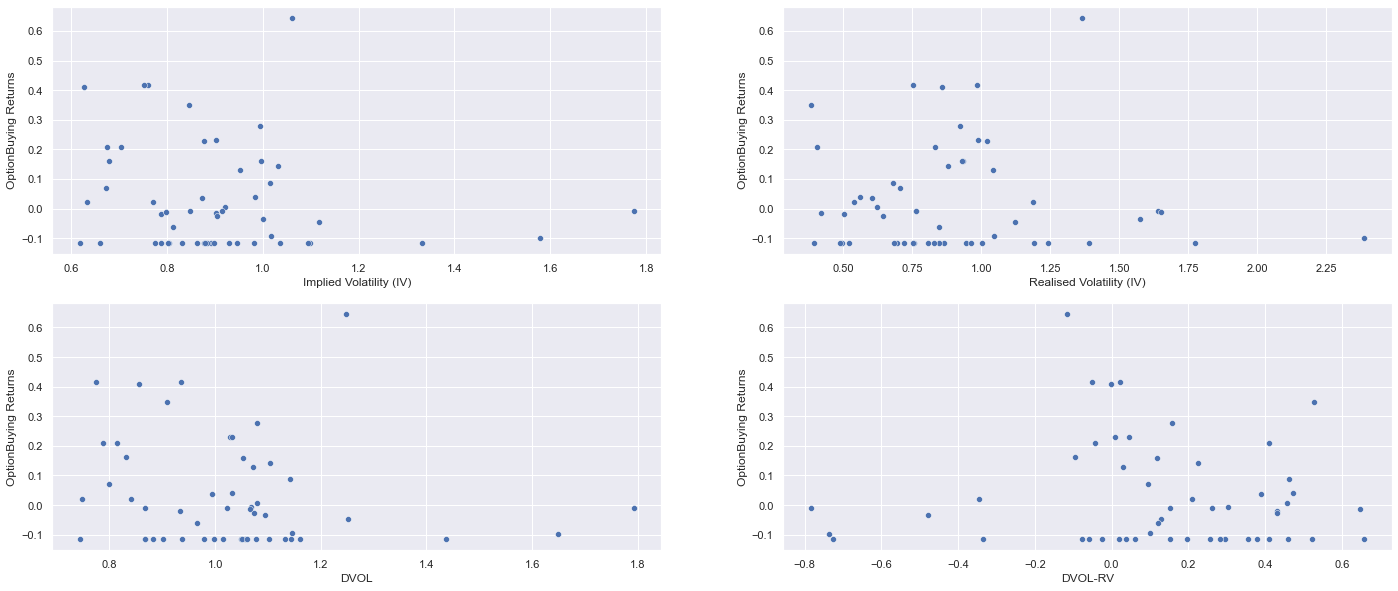

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,10))

# Plotting the absolute price move against the option buying strategy returns
# sns.scatterplot(x=abs(weekly_data.price_change), y=lyra_eth.optionReturns, ax=axes[0,0]);
# axes[0,0].set_xlabel('Abs Price Move');
# axes[0,0].set_ylabel('OptionBuying Returns');
sns.scatterplot(x=option_buyer.sigma_open, y=option_buyer.optionReturns, ax=axes[0,0]);
axes[0,0].set_xlabel('Implied Volatility (IV)');
axes[0,0].set_ylabel('OptionBuying Returns');


# Plotting the Implied Volatility (IV) against the option buying strategy returns
sns.scatterplot(x=weekly_data.realised_vol_start, y=option_buyer.optionReturns, ax=axes[0,1]);
axes[0,1].set_xlabel('Realised Volatility (IV)');
axes[0,1].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the option buying strategy returns
sns.scatterplot(x=weekly_dvol.iloc[1:,:].dvol_open/100, y=option_buyer.optionReturns, ax=axes[1,0]);
axes[1,0].set_xlabel('DVOL');
axes[1,0].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the enhanced perp strategy returns
sns.scatterplot(x=weekly_dvol.iloc[1:,:].dvol_open/100 - weekly_data.realised_vol_start, y=option_buyer.optionReturns, ax=axes[1,1]);
axes[1,1].set_xlabel('DVOL-RV');
axes[1,1].set_ylabel('OptionBuying Returns');


# weekly_dvol.rename(columns={'open':'dvol_open'},inplace=True)
option_seller.rename(columns={'optionReturns':'lyra_sell'},inplace=True)
straddle_sell.rename(columns={'optionReturns':'straddle_sell'},inplace=True)



We take particular interest in the last chart showing weekly trading returns vs the difference of DVOL and realised volalitity. For the option strategy, the majority of postive returns are clustered in middle of the (DVOL - Realised Volality) x-axis. 

On the right hand side of the x-axis we have areas where DVOL (an average measure of average option IVs) is much higher than realised volatility. One can say options are expensive in these areas as the market needs to move significantly more than it has been in order to just recover the option premium. In these weeks purchasing options may not be the best trade

On the left hand side of the x-axis we have areas where realised volatility is higher than implied volatilities - typically this means the market has just had some very large moves.In these areas it makes sense that our momentum signal will perform poorly since the market is not trending in one direction but rather having large fluctuations. In weeks when we have less confidence in our signal we rather not trade options given the possibility of losing the entire interest amount.

We note that the current perpetual strategy returns do not exhibit the same extent of clustering.





### Test Volatility Regime Dependent Strategies
We then try 2 improved strategies to test how the strategy performs when filtering trading based on the volatility regime.
1. In weeks where the DVOL premium is an outlier we don't take any trade, in all other weeks we purchase options (Options V2.0)

2. In weeks where the DVOL premium is an outlier we use our current perp strategy, in all other weeks we purchase options (Options+Perp)

In [8]:
dvol_premium_threshold = 0.23
combined_strats = pd.concat([weekly_data[['price_change','position']]
                          ,perp_enhanced['perpReturns']
                          ,option_buyer[['optionReturns','sigma_open']]
                          ,weekly_data.realised_vol_start
                          ,option_seller['lyra_sell']
                          ,straddle_sell['straddle_sell']
                          ,weekly_dvol.dvol_open/100]
                        ,axis=1)

combined_strats['dvol_premium'] = combined_strats['dvol_open']-combined_strats['realised_vol_start']

# First idea
combined_strats['optionsV2_0'] = np.where( (combined_strats['dvol_premium'] > dvol_premium_threshold) | (combined_strats['dvol_premium'] < -dvol_premium_threshold),0,combined_strats['optionReturns'])

# Second idea
combined_strats['options_perp'] = np.where( (combined_strats['dvol_premium'] > dvol_premium_threshold) | (combined_strats['dvol_premium'] < -dvol_premium_threshold) ,combined_strats['perpReturns'],combined_strats['optionReturns'])


num_weeks = combined_strats.shape[0]

improved_strat_results = pd.DataFrame.from_dict( {'Perp Imprv':perp_alpha_enhanced,'Options Buyer':option_buyer_alpha,
                         'Options Buyer++':combined_strats.optionsV2_0.sum()/(num_weeks/52),
                         'Options+Perp':combined_strats.options_perp.sum()/(num_weeks/52)} ,orient ='index')

improved_strat_results.rename(columns ={0:'Trading Alpha APR%'},inplace=True)

display(round(improved_strat_results,3))


,Trading Alpha APR%
Perp Imprv,1.317
Options Buyer,1.500
Options Buyer++,2.340
Options+Perp,2.355


### Plot Return Profiles

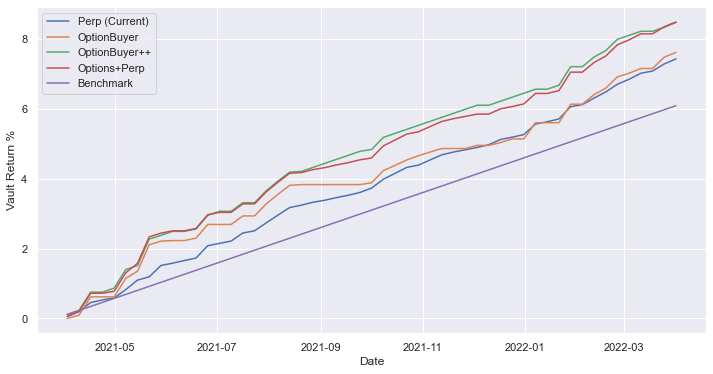

In [9]:
# Plot the comparison of the returns for strategies with improvements
plt.figure(figsize=(12,6))

plt.plot((perp_enhanced.perpReturns+interest).cumsum())
plt.plot((option_buyer.optionReturns+interest).cumsum())
plt.plot((combined_strats.optionsV2_0+interest).cumsum())
plt.plot((combined_strats.options_perp+interest).cumsum())
plt.plot((abs(combined_strats.position)*interest).cumsum())
plt.ylabel('Vault Return %')
plt.xlabel('Date')
plt.legend(['Perp (Current)','OptionBuyer','OptionBuyer++','Options+Perp','Benchmark'])
plt.show()

Adjusting the option strategy in weeks where the DVOL premium is outside our range provides promising results. 

Doing nothing in those weeks gives similar results to executing perpetual future trades in those weeks. Importantly we are able to signficantly improve the trading alpha by using options in our weekly trading strategy which provides a 1.4x boost to the underlying yield.  

# Conclusion

We make the below conclusions:
 1. It is imperative for a vault to have the flexibility to take advantage of both up and down price movements in order to provide returns throughout market cycles. Bi-directional vaults outperformed static directional vaults for all strategies tested.
 2. Using a squeeth based, option selling or straddle based strategy does not provide any meaningful trading returns as leveraged exposure to price movements are limited. 
 3. Using a simple options purchasing strategy provides similar returns to the enhanced perp strategy currently used by the PMSUDC vault. 
 4. Adjusting option purchasing activities based on the volatility regime provides a significant boost the trading returns generated resulting in base yields being enhanced by 1.4x without having to put underlying capital at further risk.
